# Used cars price prediction project

The dataset contains information about new and used cars sales in Germany. It was scraped from AutoScout24 and it's available on  Kaggle (https://www.kaggle.com/datasets/ander289386/cars-germany).

The goal of this project is to analyze and prepare the data to build models for price prediction.

### Import libraries 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Exploratory data analysis

In [2]:
data = pd.read_csv("autoscout24-germany-dataset.csv")

In [3]:
data.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011


In [4]:
data.info()
data.duplicated().value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offerType  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


False    44265
True      2140
dtype: int64

We can see there are 46 405 entries and columns model, gear, hp and year contain some missing values and there are also some duplicated rows. Data types of all columns are fine. Let's remove duplicates and rows with missing values.

In [5]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

#check dataset again
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43947 entries, 0 to 46399
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    43947 non-null  int64  
 1   make       43947 non-null  object 
 2   model      43947 non-null  object 
 3   fuel       43947 non-null  object 
 4   gear       43947 non-null  object 
 5   offerType  43947 non-null  object 
 6   price      43947 non-null  int64  
 7   hp         43947 non-null  float64
 8   year       43947 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


### Brand distribution check

Let's make a highlevel check that entries are reflecting a plausible brand mix. 

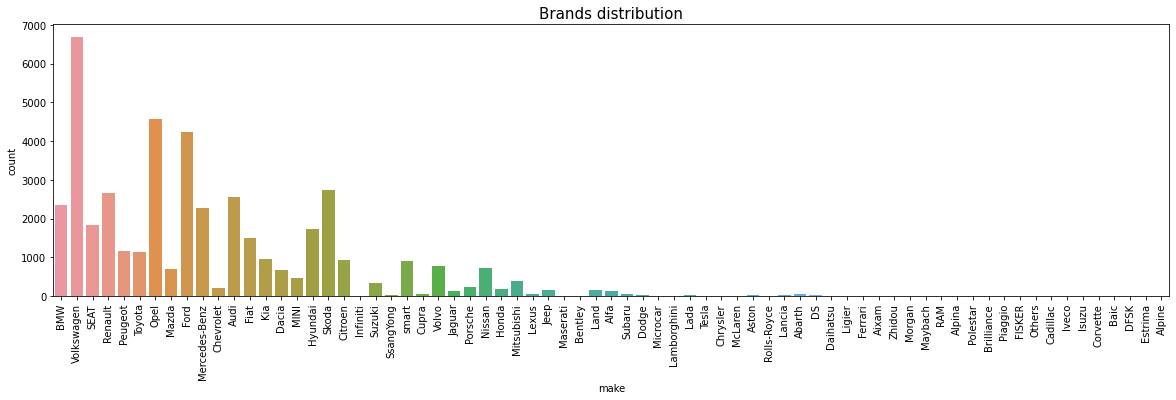

In [6]:
plt.figure(figsize=(20,5))
sns.countplot(data=data, x="make")
plt.xticks(rotation=90)
plt.title("Brands distribution", size=15)
plt.show()

Brands seem to be represented plausibly. However, the dataset contains different types of vehicles - passenger cars, commercial vehicles, trucks and caravans. In order to increase the accuracy of prediction models, let's remove trucks and caravans.

In [7]:
makes_to_remove = ["Caravans-Wohnm", "Piaggio", "Truck-Lkw", "DAF", "Trailer-Anhänger", "Others"]

data.drop(data[data.make.isin(makes_to_remove)].index, inplace=True)

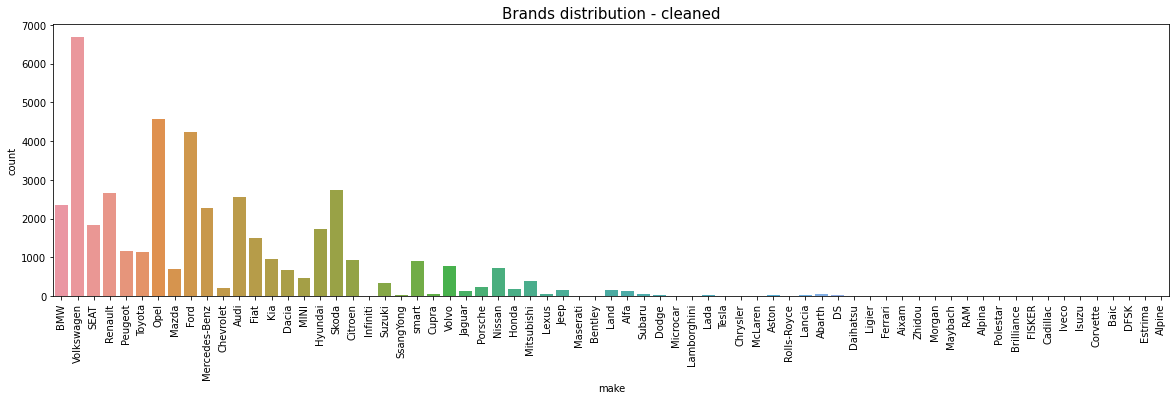

In [8]:
plt.figure(figsize=(20,5))
sns.countplot(data=data, x="make")
plt.xticks(rotation=90)
plt.title("Brands distribution - cleaned", size=15)
plt.show()

Final dataset looks as follows:

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43943 entries, 0 to 46399
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    43943 non-null  int64  
 1   make       43943 non-null  object 
 2   model      43943 non-null  object 
 3   fuel       43943 non-null  object 
 4   gear       43943 non-null  object 
 5   offerType  43943 non-null  object 
 6   price      43943 non-null  int64  
 7   hp         43943 non-null  float64
 8   year       43943 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


### Categorical data check

In [10]:
data.fuel.value_counts()

Gasoline             27243
Diesel               14683
Electric/Gasoline     1039
Electric               639
CNG                    113
LPG                    109
Electric/Diesel         49
Others                  45
-/- (Fuel)              20
Ethanol                  2
Hydrogen                 1
Name: fuel, dtype: int64

There are many types with very low representation. Let's merge all but Gasoline and Diesel under just one type called Others.

In [11]:
fuel_types = list(data.fuel.unique())
fuel_types.remove("Gasoline")
fuel_types.remove("Diesel")

for fuel_type in fuel_types:
    data.fuel.replace(fuel_type, "Others", inplace=True)

#check the change
data.fuel.value_counts()

Gasoline    27243
Diesel      14683
Others       2017
Name: fuel, dtype: int64

In [12]:
data.gear.value_counts()

Manual            28748
Automatic         15141
Semi-automatic       54
Name: gear, dtype: int64

There is a very low representation of Semi-automatic type. Let's plug it under Automatic.

In [13]:
data.gear.replace("Semi-automatic", "Automatic", inplace=True)

#check the change
data.gear.value_counts()

Manual       28748
Automatic    15195
Name: gear, dtype: int64

In [14]:
data.offerType.value_counts()

Used              38549
Demonstration      2230
Pre-registered     2073
Employee's car     1080
New                  11
Name: offerType, dtype: int64

It's pointless to have only 11 representatives of new cars. These records will be removed from the dataset.

In [15]:
data = data[data.offerType != "New"]

#check the change
data.offerType.value_counts()

Used              38549
Demonstration      2230
Pre-registered     2073
Employee's car     1080
Name: offerType, dtype: int64

## Data analysis

### Numerical variables

First of all, let's examine the variable we are going to predict - price.

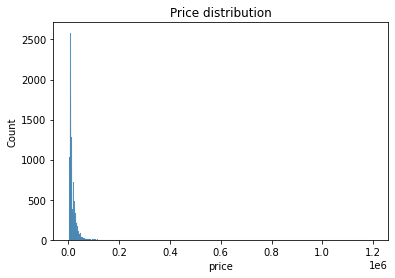

count    4.393200e+04
mean     1.653293e+04
std      1.937401e+04
min      1.100000e+03
25%      7.490000e+03
50%      1.099000e+04
75%      1.949000e+04
max      1.199900e+06
Name: price, dtype: float64

In [16]:
sns.histplot(data=data, x="price")
plt.title("Price distribution")
plt.show()
data.price.describe()

Price distribution is right-skewed with some outliers so better to perform log transformation.

In [17]:
data.price = np.log(data.price)

print(f"Price skewness: {round(data.price.skew(), 4)}")

Price skewness: 0.6343


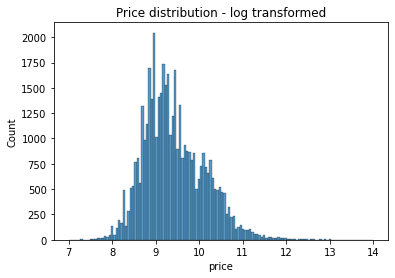

count    43932.000000
mean         9.423255
std          0.701822
min          7.003065
25%          8.921324
50%          9.304741
75%          9.877657
max         13.997749
Name: price, dtype: float64

In [18]:
sns.histplot(data=data, x="price")
plt.title("Price distribution - log transformed")
plt.show()
data.price.describe()

The distribution is still significantly right-skewed so let's run log transformation one more time.

In [19]:
data.price = np.log(data.price)

print(f"Price skewness: {round(data.price.skew(), 4)}")

Price skewness: 0.4105


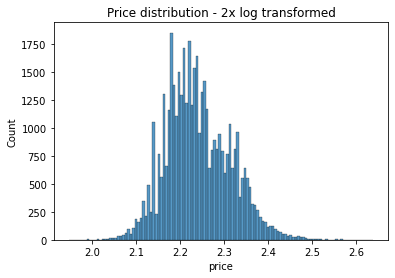

count    43932.000000
mean         2.240470
std          0.073266
min          1.946348
25%          2.188444
50%          2.230524
75%          2.290275
max          2.638897
Name: price, dtype: float64

In [20]:
sns.histplot(data=data, x="price")
plt.title("Price distribution - 2x log transformed")
plt.show()
data.price.describe()

Price distribution now reached a satisfying level of normal distribution (skewness lower than 0.5). We can proceed to other numerical variables - mileage, hp and year.

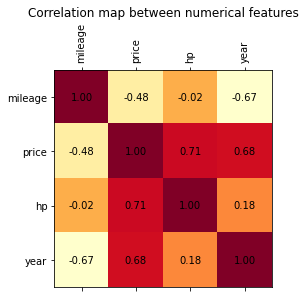

In [21]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(data.corr(), cmap=plt.cm.YlOrRd)

for (x, y), value in np.ndenumerate(data.corr()):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")

ax.set_xticks(range(0, len(data.corr())))
ax.set_xticklabels(data.corr().columns, rotation=90)
ax.set_yticks(range(0, len(data.corr())))
ax.set_yticklabels(data.corr().columns)
plt.title("Correlation map between numerical features")
plt.show()

All variables are relevant for price determination and there is no significant multicolinarity present so we can consider all variables in predictive models.

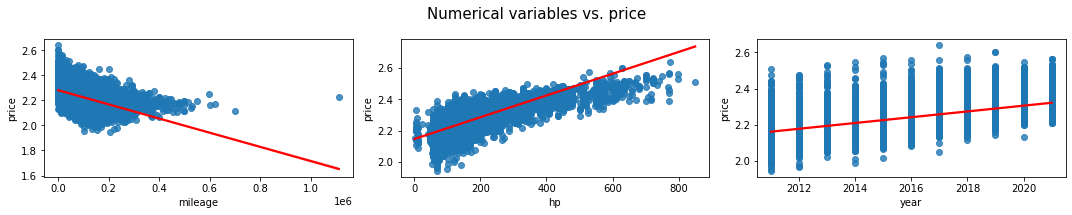

In [22]:
fig, axs = plt.subplots(ncols= 3, nrows=1, figsize=(15,3))
for feature, ax in zip(["mileage", "hp", "year"], axs.flatten()):
    sns.regplot(x=feature, y="price", data=data, ax=ax, line_kws={"color":"red"})
plt.suptitle("Numerical variables vs. price", size=15)
plt.tight_layout()

### Categorical variables

There are only 3 nominal variables - fuel, gear and offerType (make and model will be disregarded for modeling)

In [23]:
nominal_variables = ["fuel", "gear", "offerType"]

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for variable in nominal_variables:
    data[variable] = encoder.fit_transform(data[variable])

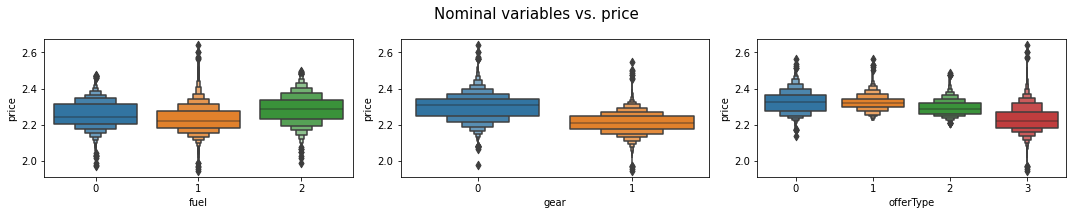

In [24]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
for feature, ax in zip(nominal_variables, axs.flatten()):
    sns.boxenplot(x=feature, y="price", data=data, ax=ax)
plt.suptitle("Nominal variables vs. price", size=15)
plt.tight_layout()

## Prediction models

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

X = data[["mileage", "fuel", "gear", "offerType", "hp", "year"]]
y = data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

### Linear regression

In [26]:
params = {"normalize": [True]}

LinReg_model = GridSearchCV(LinearRegression(), param_grid=params)

LinReg_model.fit(X_train, y_train)

print(f"Best score: {round(LinReg_model.best_score_, 4)}")
print(f"Train set R2 score: {round(LinReg_model.score(X_train, y_train), 4)}")
print(f"Test set R2 score: {round(LinReg_model.score(X_test, y_test), 4)}")

Best score: 0.8649
Train set R2 score: 0.865
Test set R2 score: 0.8656


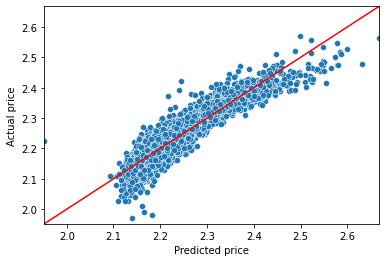

In [27]:
model = LinReg_model

lineStart = min(min((y_test)), min(model.predict(X_test)))
lineEnd = max(max(y_test), max(model.predict(X_test)))

sns.scatterplot(model.predict(X_test), y_test)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], color="red")
plt.xlim([lineStart, lineEnd])
plt.ylim([lineStart, lineEnd])
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.show()

### K Neighbors regression

In [28]:
params = {"n_neighbors": range(1,21)}

kneighbors = GridSearchCV(KNeighborsRegressor(), param_grid=params)
kneighbors.fit(X_train, y_train)

print(f"Best parameters: {kneighbors.best_params_}")
print(f"Best score: {round(kneighbors.best_score_, 4)}")

print(f"Train set R2 score: {round(kneighbors.score(X_train, y_train), 4)}")
print(f"Test set R2 score: {round(kneighbors.score(X_test, y_test), 4)}")

Best parameters: {'n_neighbors': 4}
Best score: 0.7517
Train set R2 score: 0.8645
Test set R2 score: 0.7628


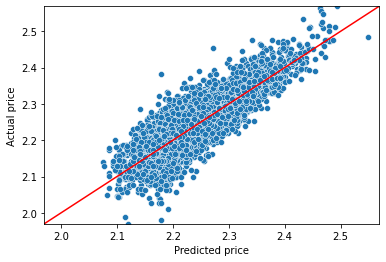

In [29]:
model = kneighbors

lineStart = min(min((y_test)), min(model.predict(X_test)))
lineEnd = max(max(y_test), max(model.predict(X_test)))

sns.scatterplot(model.predict(X_test), y_test)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], color="red")
plt.xlim([lineStart, lineEnd])
plt.ylim([lineStart, lineEnd])
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.show()

### Random forest regression

In [30]:
params = {"n_estimators": [100, 200, 300]}

random_forest = GridSearchCV(RandomForestRegressor(), param_grid=params)
random_forest.fit(X_train, y_train)

print(f"Best parameters: {random_forest.best_params_}")
print(f"Best score: {round(random_forest.best_score_, 4)}")

print(f"Train set R2 score: {round(random_forest.score(X_train, y_train), 4)}")
print(f"Test set R2 score: {round(random_forest.score(X_test, y_test), 4)}")

Best parameters: {'n_estimators': 300}
Best score: 0.9005
Train set R2 score: 0.9843
Test set R2 score: 0.9017


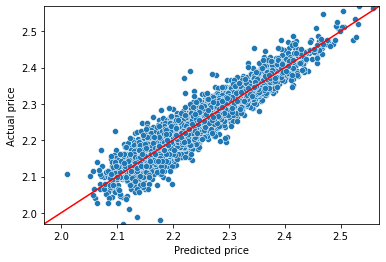

In [31]:
model = random_forest

lineStart = min(min((y_test)), min(model.predict(X_test)))
lineEnd = max(max(y_test), max(model.predict(X_test)))

sns.scatterplot(model.predict(X_test), y_test)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], color="red")
plt.xlim([lineStart, lineEnd])
plt.ylim([lineStart, lineEnd])
plt.xlabel("Predicted price")
plt.ylabel("Actual price")
plt.show()

## Summary

The most suitable model seems to be random forest regression which performs with the highest R2 scores for both train and test sets.